In [7]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import actual_inference
from pyhf_pymc import slow_inference


## Model

In [8]:
N = 5
nBins = N
obs = jnp.array([70., 70., 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

## Use `actual_inference.py`

In [9]:
expData_op = actual_inference.make_op(model)

In [15]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, 1000, 1, 'Metropolis')

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [13]:
post_data, post_pred, prior_pred = slow_inference.sampling(prepared_model, 100, 1, 'Metropolis')

Only 1 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 121 seconds.
/Users/malinhorstmann/Documents/pyhf_pymc/src/pyhf_pymc/slow_inference.py:76: UserWarning: The number of samples is too small to check convergence reliably.
  post_data = pm.sample(n_samples, chains=n_chains, cores=4, step=step1)
Sampling: [Expected_Data]


Sampling: [Expected_Data, Normals, Unconstrained]


## Plotting

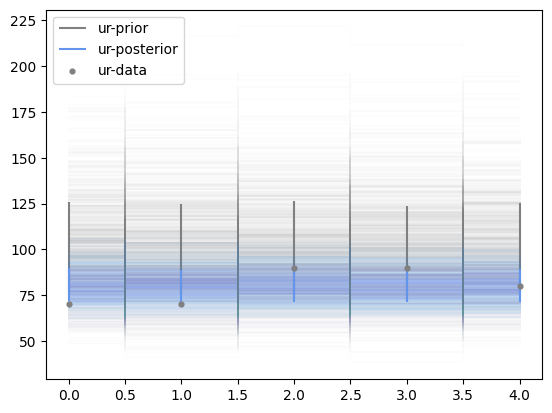

In [16]:
# ur Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'grey', label='ur-prior');

# ur Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='ur-posterior')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'grey', s=12, zorder = 999, label = "ur-data")

plt.legend(loc='upper left')